<a href="https://colab.research.google.com/github/vadim-vic/Signal-separation/blob/main/7_MixAndPlot_SSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# An example of Singular Spectrum Analysis that plots two first Principal
# Components

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from google.colab import drive
drive.mount('/content/drive')
%ls

Mounted at /content/drive
drive/  inphase_quadrature_data.json  inphase_quadrature_noise.json  sample_data/


In [2]:
# Read the uploaded files
with open('inphase_quadrature_data.json') as f:
  data = np.array(json.load(f))
with open('inphase_quadrature_noise.json') as f:
  noise = np.array(json.load(f))

In [3]:
# Sigular spectrum analysis
# Check the complex numbers
#---
def vec2hankel(vec, ncols):
  hankel = np.empty((len(vec)-ncols+1, ncols))
  for i in range(len(hankel)):
    hankel[i] = vec[i:i+ncols]
  return hankel
#---
def hankel2vec(hankel):
  nrows, ncols = hankel.shape
  vec = np.zeros((nrows+ncols-1))
  # first upper triangle of the hankel matrix
  for i in range(ncols):
    vec[i] = np.trace(np.flip(hankel[0:0+ncols,:], axis=0), offset= -ncols+1+i )/(i+1)
    #print(i, vec[i])
  # the body of the matrix
  for i in range(ncols+1,nrows):
    vec[i-1] = np.trace(np.flip(hankel[i-ncols:i,:], axis=0))/ncols
    #print(i, vec[i])
  # the rest of the matrix
  for i in range(nrows,nrows+ncols):
    vec[i-1] = np.trace(np.flip(hankel[nrows-ncols:nrows,:], axis=0), offset= -nrows+i )/(ncols+nrows-i)
    #print(nrows-ncols,nrows, -nrows+i, ncols+nrows-i)
    #print(hankel[nrows-ncols:nrows,:])
    #print(i, vec[i])
  return vec
#---
def ssa(vec, ncols, ncomps):
  h  = vec2hankel(x,ncols)
  u, s, vt = np.linalg.svd(h)
  # Reconstruct the first ncomps SVD sigular values
  h1 = u[:,0:ncomps] @ np.diag(s[0:ncomps]) @ vt[0:ncomps,:]
  hr = u[:,0:ncomps] @ np.diag(s[0:ncomps]) # @ vt[0:ncomps,:] # Suppress rotation
  # Reconstruct the sourse vector of the same length
  x1 = hankel2vec(h1)
  # Return both the hankel matrix and the vector
  # Return results of analysis
  lambd = s[0:ncomps]         # NEW
  rotat =  vt[0:ncomps,:]     # NEW
  # rotat = rotat.reshape(-1)   # NEW
  return x1, h1, hr, lambd, rotat

  # x1, h1, hr, lambd, rotat = ssa(vec, ncols, ncomps)

In [ ]:
# Show the first 1000 original and mixed signals with their state space

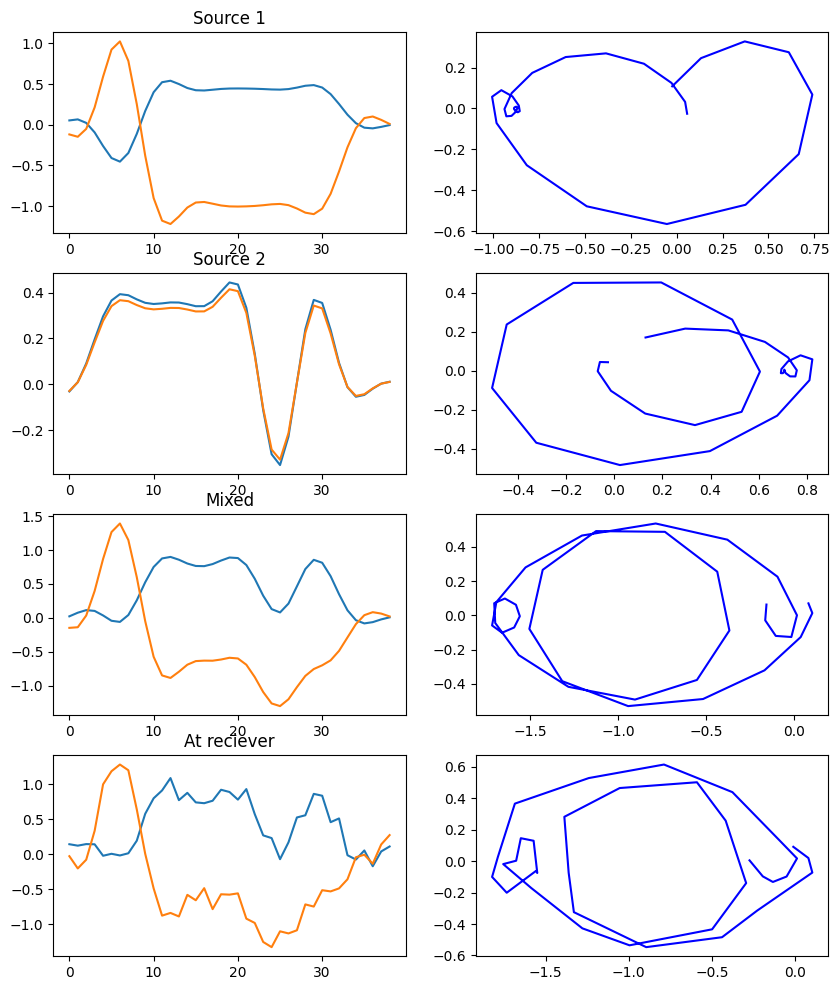

In [4]:
# SANDBOX
# Mix several signals from transmitters and a noise
i = 935
k = 64
z = 36
# Extract signas
tr1 = data[i]
tr2 = data[i+k]
mix = tr1 + tr2
at_r = mix + noise[i+z]
# Compute state space
ncols, ncomps = 4, 2
x = tr1[0,:]
v1, v2, h_tr1, _, _ = ssa(x, ncols, ncomps)
x = tr2[0,:]
v1, v2, h_tr2, _, _ = ssa(x, ncols, ncomps)
x = mix[0,:]
v1, v2, h_mix, _, _ = ssa(x, ncols, ncomps)
x = at_r[0,:]
v1, v2, h_at_r, _, _ = ssa(x, ncols, ncomps)

# Plot the signals in time domain
fig, axes = plt.subplots(4, 2, figsize=(10, 12))  # 3 rows, 2 columns
axes[0, 0].plot(tr1[0])
axes[0, 0].plot(tr1[1])
axes[0, 0].set_title('Source 1')
axes[1, 0].plot(tr2[0])
axes[1, 0].plot(tr2[1])
axes[1, 0].set_title('Source 2')
axes[2, 0].plot(mix[0])
axes[2, 0].plot(mix[1])
axes[2, 0].set_title('Mixed')
axes[3, 0].plot(at_r[0])
axes[3, 0].plot(at_r[1])
axes[3, 0].set_title('At reciever')
# Plot the signal trajectory in the state space
axes[0, 1].plot(h_tr1[:,0], h_tr1[:,1], 'b-')
axes[1, 1].plot(h_tr2[:,0], h_tr2[:,1], 'b-')
axes[2, 1].plot(h_mix[:,0], h_mix[:,1], 'b-')
axes[3, 1].plot(h_at_r[:,0], h_at_r[:,1], 'b-')
plt.show()


In [5]:
# Sinusoidal data fit
from scipy.optimize import curve_fit

In [6]:
# Define the sinusoidal function
def sinusoidal(t, A, B, C, D):
    return A * np.sin(B * t + C) + D

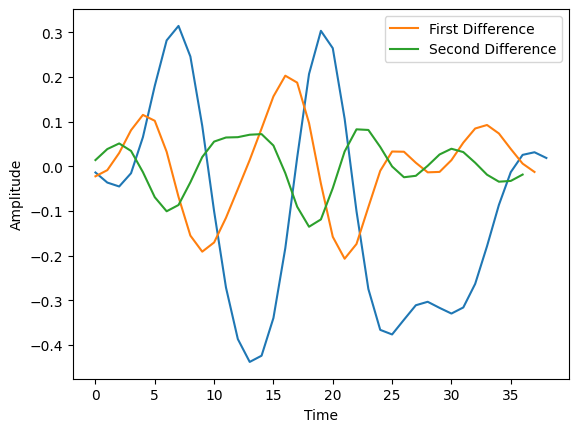

In [7]:
# Plot the first finite difference

x = data[12,0,:]
plt.plot(x)
#plt.show()
first_diff = np.diff(x)
plt.plot(first_diff, label='First Difference')
#plt.show()
second_diff = np.diff(first_diff)
plt.plot(second_diff, label='Second Difference')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

y_data = second_diff # use below to fit

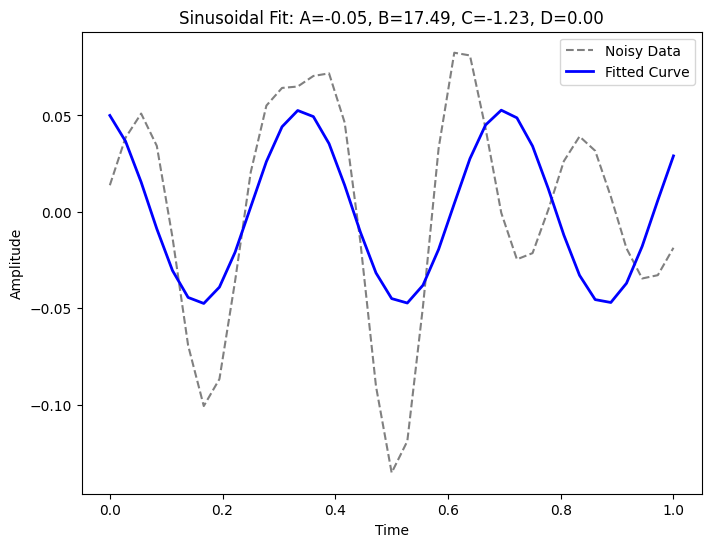

Fitted parameters: A=-0.05, B=17.49, C=-1.23, D=0.00


In [8]:
# Generate some example data with noise
np.random.seed(0)  # For reproducibility
# t_data = np.linspace(0, 10, 100)  # Time values
t_data = np.linspace(0, 1, len(y_data))  # Time values
# A_true, B_true, C_true, D_true = 2.0, 1.0, 0.5, 1.0  # True parameters
# y_data = A_true * np.sin(B_true * t_data + C_true) + D_true
# y_data += 0.3 * np.random.normal(size=t_data.shape)  # Add noise

# Initial guess for the parameters: [Amplitude, Frequency, Phase, Offset]
initial_guess = [1.0, 15.0, 0.0, 0.0]

# Perform the curve fitting
params, covariance = curve_fit(sinusoidal, t_data, y_data, p0=initial_guess)

# Extract the fitted parameters
A_fit, B_fit, C_fit, D_fit = params

# Plot the data and the fitted curve
plt.figure(figsize=(8, 6))
plt.plot(t_data, y_data, label='Noisy Data', color='gray', linestyle='--')
plt.plot(t_data, sinusoidal(t_data, *params), label='Fitted Curve', color='blue', linewidth=2)
plt.title(f'Sinusoidal Fit: A={A_fit:.2f}, B={B_fit:.2f}, C={C_fit:.2f}, D={D_fit:.2f}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the fitted parameters
print(f"Fitted parameters: A={A_fit:.2f}, B={B_fit:.2f}, C={C_fit:.2f}, D={D_fit:.2f}")


DELETE ALL AFTER THIS LINE